In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt

#Loading Mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(x_train.shape,x_test.shape,"\n")
print(y_train.shape,y_test.shape,"\n")

(60000, 28, 28) (10000, 28, 28) 

(60000,) (10000,) 



#Extracting features by doing dimensionality reduction for Training and Testing set and get the centroid of each sub-image, after splitting the image into 4X4 sub-images

In [26]:
def feature_extraction(data):
    extracted_features = np.zeros([data.shape[0], 4*4*2]) #The image is splitted into (7*7) 16 sub-images,
    x, y = data.shape[1:]                                 #with x, y coordinates for each sub-image
    x = (x // 4)
    y = (y // 4)

    for t in range(data.shape[0]):
        image = data[t]

        for i in range(16):
            start_row = (i//4)*x
            start_col = (i%4)*y

            img = image[start_row:start_row+x, start_col:start_col+y]
            x_indices, y_indices = np.indices(img.shape)
            total_img_values = img.sum().sum()

            if total_img_values == 0:
                x_index, y_index = img.shape
                x_index /= int(x_index)
                y_index /= int(y_index)

            else:
                x_centroid = np.multiply(x_indices, img).sum().sum() / total_img_values
                y_centroid = np.multiply(y_indices, img).sum().sum() / total_img_values

                x_index = int(x_centroid) + start_row
                y_index = int(y_centroid) + start_col

            extracted_features[t,i] = x_index
            extracted_features[t,i+16] = y_index

    return extracted_features

In [27]:
array_train = feature_extraction(x_train)
array_test = feature_extraction(x_test)

#Plotting an image with its centroids scattered with red dots on each 7*7 sub-image

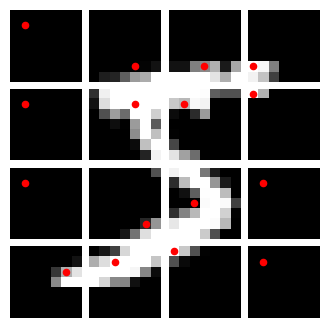

In [32]:
img = 0
centroid_coordinates = array_train[img].reshape(2, 16).T
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        start_row, start_col = i * 7, j * 7
        sub_img = x_train[img][start_row:start_row+7, start_col:start_col+7]

        x_global, y_global = centroid_coordinates[idx]

        x_local = x_global % 7
        y_local = y_global % 7

        ax[i, j].imshow(sub_img, cmap='gray', interpolation='nearest')
        ax[i, j].scatter(y_local, x_local, c='red', s=20)
        ax[i, j].axis('off')

plt.show()

#Normalize the features

In [33]:
for i in range (array_train.shape[1]):
    array_train[:,i] = (array_train[:,i] - np.mean(array_train[:,i])) / np.std(array_train[:,i])
    array_test[:,i] = (array_test[:,i] - np.mean(array_test[:,i])) / np.std(array_test[:,i])

#Creating validation set

In [34]:
array_val = array_train[:6000,:]
array_train = array_train[6000:,:]
y_val = y_train[:6000]
y_train = y_train[6000:]

In [35]:
array_val.shape, y_val.shape, array_train.shape, y_train.shape

((6000, 32), (6000,), (54000, 32), (54000,))

#implementing sigmoid activation function

In [36]:
def sigmoid(array):
    return 1/(1+np.exp(-array.copy(),dtype = np.float128))

#Defining Softmax activation function

In [37]:
def softmax(array):
    post_values = array.copy()
    post_values = np.exp(post_values, dtype = np.float128)
    sum_of_output_values = np.sum(post_values.copy(),axis=1)
    for i in range(post_values.shape[1]):
        post_values[:,i] /= sum_of_output_values
    return post_values

#Defining function convert the integer number to a one-hot dimension with respect to the number of classes in the set

In [38]:
def dimensions(y_train):
    real_y = np.zeros(shape=(1,10))
    real_y[:,y_train] = 1
    return real_y

#Defining function computes the gradient **rate of change** of the loss values with respect to the weights

In [39]:
def sigmoid_gradient(array):
    return np.multiply(array,1-array)

#Defining the loss function **Cross entropy** for classification with **L2-Regularization**

In [40]:
def loss_function(x,y,parameters, reg_lambda):
  h_theta = x
  real_y = dimensions_10(y)
  m = h_theta.shape[0]

  for i in range(parameters.shape[0]-1):
    h_theta = sigmoid(np.dot(h_theta,parameters[i].parameter_matrix))

  h_theta = softmax(np.dot(h_theta,parameters[parameters.shape[0]-1].parameter_matrix))
  cost = np.multiply(real_y.copy(),np.log(h_theta)) + np.multiply(1-real_y.copy(),np.log(1-h_theta))
  regularized_cost = 0
  for i in range(parameters.shape[0]):
    regularized_cost += np.sum((np.square(np.array(parameters[i].parameter_matrix))))
  regularized_cost *= (reg_lambda/(2*m))
  cost = np.sum(cost)
  cost /= m
  cost = -cost
  cost += regularized_cost
  print("cost is ", end="")
  return cost

#Defining the matrix class which is desired for initalize the weight matrix

In [41]:
class matrix:
    def __init__(self, current_layer, next_layer):
        self.current_layer = current_layer
        self.next_layer = next_layer
        self.parameter_matrix = np.random.normal(size=(self.current_layer,self.next_layer))

    def get_parameters(self):
        return self.parameter_matrix

#Defining the Neural Network class to build the desired architecture

In [42]:
class Neural_Network:
    def __init__(self, layers, neurons):
        self.layers = layers
        self.neurons = neurons
        self.parameter_matrices = np.empty(shape=(self.layers - 1,),dtype=matrix)
        self.outputs = np.zeros(shape=(self.layers,),dtype=matrix)

    def preparing(self, train):
        data = train.copy()
        self.parameter_matrices[0] = matrix(data.shape[1], self.neurons)
        self.parameter_matrices[self.layers - 2] = matrix(self.neurons, 10)

        for i in range(1,self.layers - 2):
            self.parameter_matrices[i] = matrix(self.neurons, self.neurons)

        return self.parameter_matrices

    def feed_forward(self,train, parameters):
        data = train.copy()
        self.outputs[0] = matrix(data.shape[0], data.shape[1])
        self.outputs[0].parameter_matrix = data.copy()

        for i in range(1,self.layers-1):
            data = sigmoid(np.dot(data,parameters[i-1].parameter_matrix))
            self.outputs[i] = matrix(data.shape[0], data.shape[1])
            self.outputs[i].parameter_matrix = data.copy()

        data = softmax(np.dot(data,parameters[self.layers - 2].parameter_matrix))
        self.outputs[self.layers - 1] = matrix(data.shape[0], data.shape[1])
        self.outputs[self.layers - 1].parameter_matrix = data.copy()
        return parameters.copy(), self.outputs

    def back_propagation(self, outputs, parameters, target, learning_rate, reg_lambda):
        actual_y = dimensions(target)
        thetas = parameters.copy()
        parameter = parameters.copy()
        data = outputs.copy()

        ########################################################
        # for output layer only
        error = np.multiply((actual_y - data[-1].parameter_matrix), sigmoid_gradient(data[-1].parameter_matrix))

        thetas[-1].parameter_matrix += np.dot(np.transpose(data[-2].parameter_matrix), error) * learning_rate
        # for output layer only
        #########################################################

        #########################################################
        # for hidden layers...

        for i in range(data.shape[0] - 2, 0 , -1):
              error = np.dot(error,np.transpose(parameter[i].parameter_matrix))
              error = np.multiply(error, sigmoid_gradient(data[i].parameter_matrix))
              thetas[i-1].parameter_matrix += (np.dot(np.transpose(data[i-1].parameter_matrix), error) + (reg_lambda/data.shape[0])*data[i-1].parameter_matrix) * learning_rate

        return thetas.copy()

#Defining a function convert the target to on-hot dimension

In [43]:
def dimensions_10(y_train):
    real_y = np.zeros(shape=(y_train.shape[0],np.unique(y_train).shape[0]))
    for i in range(0,y_train.shape[0]):
        real_y[i,y_train[i]] = 1
    return real_y

#Defining the accuracy test function

In [44]:
def accuracy(data,target,parameters):
    real_y = dimensions_10(target.copy())
    results = data.copy()
    thetas = parameters.copy()

    for i in range(thetas.shape[0]-1):
        results = sigmoid(np.dot(results, thetas[i].parameter_matrix))

    results = softmax(np.dot(results, thetas[thetas.shape[0]-1].parameter_matrix))
    hypothesis = np.zeros([results.shape[0],results.shape[1]])
    count = 0

    for m in range(0,results.shape[0]):
        index_ = 0
        biggest = results[m,index_]

        for n in range(1,results.shape[1]):
            if biggest < results[m,n]:
                biggest = results[m,n]
                index_ = n

        hypothesis[m,index_] = 1

    for l in range(0,real_y.shape[0]):
        for v in range(0,real_y.shape[1]):
            if real_y[l,v] == 1 and hypothesis[l,v] == 1:
                count = count + 1


    return(count/results.shape[0])*100

#initalize the Neural Network architecture

In [45]:
N = Neural_Network(7,32)

#Defining fit Function for training

In [46]:
def fit(array_train, iterations, learning_rate, reg_lambda):
    thetas = N.preparing(array_train.copy())
    for iterations in range(0,iterations):
        for i in range(0,array_train.shape[0]):
            thetas, outputs = N.feed_forward(array_train[i:i+1,:],thetas)
            thetas = N.back_propagation(outputs,thetas,y_train[i],learning_rate,reg_lambda)

        print("epoch ",iterations+1,": \nLoss function on Training set",loss_function(array_train,y_train,thetas, reg_lambda))
        print("epoch ",iterations+1,": \nLoss function on Validation set",loss_function(array_val,y_val,thetas, reg_lambda))
        print("=========================================================")
    return thetas

In [47]:
thetas = fit(array_train, 20, 0.01, 1e-5)

cost is epoch  1 : 
Loss function on Training set 2.1640363710679565911
cost is epoch  1 : 
Loss function on Validation set 2.124678950230881526
cost is epoch  2 : 
Loss function on Training set 1.675276627538930411
cost is epoch  2 : 
Loss function on Validation set 1.6350911430087318297
cost is epoch  3 : 
Loss function on Training set 1.4460326433131455233
cost is epoch  3 : 
Loss function on Validation set 1.4127215106169118634
cost is epoch  4 : 
Loss function on Training set 1.3074397272656545762
cost is epoch  4 : 
Loss function on Validation set 1.2828998728697578095
cost is epoch  5 : 
Loss function on Training set 1.2082262423855727476
cost is epoch  5 : 
Loss function on Validation set 1.1904294760914933549
cost is epoch  6 : 
Loss function on Training set 1.1245973876466538142
cost is epoch  6 : 
Loss function on Validation set 1.1109140679170505181
cost is epoch  7 : 
Loss function on Training set 1.0593515077856785409
cost is epoch  7 : 
Loss function on Validation set 1.

#printing the accuracy after training on the training set on **Training set**

In [48]:
print("accuracy of training set is: ", accuracy(array_train,y_train,thetas))

accuracy of training set is:  86.4037037037037


#printing the accuracy after training on the training set on **Test set**

In [49]:
print("accuracy on test set: ", accuracy(array_test,y_test,thetas))

accuracy on test set:  86.02


#defining a function preparing for prediction

In [50]:
def preparing(result,parameters):
    results = result.copy()
    thetas = parameters.copy()
    for i in range(thetas.shape[0]-1):
        results = sigmoid(np.dot(results, thetas[i].parameter_matrix))

    results = softmax(np.dot(results, thetas[thetas.shape[0]-1].parameter_matrix))

    post_result = np.zeros(shape=(results.shape[0],))
    for i in range(results.shape[0]):
        index = np.argmax(results[i,:])
        post_result[i]=index
    return post_result

#See the Score

In [51]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [52]:
results = preparing(array_test,thetas)

#Confusion matrix

In [53]:
confusion_matrix(y_test,results)

array([[ 910,    0,    5,   14,    2,   21,   16,    0,   10,    2],
       [   0, 1106,    4,    7,    2,    3,    7,    1,    4,    1],
       [  15,   10,  858,   46,   13,    4,   14,   35,   35,    2],
       [   9,    7,   18,  834,    1,   65,    6,   23,   37,   10],
       [   2,    0,    5,    4,  877,    4,   10,    4,   14,   62],
       [  10,    5,    7,   76,    6,  677,   44,   12,   38,   17],
       [  10,    4,    8,    2,   10,   31,  884,    2,    7,    0],
       [   1,   13,   16,    8,    9,    4,    2,  869,   11,   95],
       [   8,   16,    9,   52,   21,   48,   37,   15,  722,   46],
       [   6,    5,    7,   14,   58,   17,    0,   25,   12,  865]])

#The accuracy score

In [54]:
accuracy_score(y_test,results)

0.8602

#F1 score

In [55]:
f1_score(y_test,results,average='micro')

0.8602

#Precision score

In [56]:
precision_score(y_test,results,average='micro')

0.8602

#Recall score

In [57]:
recall_score(y_test,results,average='micro')

0.8602